# Setup

In [73]:
# import statements
import os
import pandas as pd
import sys
sys.path.insert(0, '../functions/')
import mRNA_ratios

# Griff's stuff
import numpy as np
import dill as pickle
import matplotlib.pyplot as plt

import promoter_solving_core as ps
import GA_core as ga

from deap import algorithms, base, creator, tools
from sympy import *
import matplotlib.cm as cm

# load some files of use for troubleshooting
log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)

In [74]:
# settings
flags = { # add additional settings that should be changed between runs here
    # general flags
    'force_rerun' : True,
    'central_gene' : 'b3601',
    'basal_conditions' : ['control__wt_glc__1', 'control__wt_glc__2'],
    'grid_use' : -1, # which of the generated constants grids do you want to use? -1 is the highest KdRNAP
    
    # basal model flags
    'basal_bool': False, # If true, use imported values for basal expression

    # mRNA ratios flags
    'basal_or_hard_val' : 'hard', # use basal conditions for ratio or some hard value
    'hard_val' : 10, # the basal log tpm value
    'use_zerod_A_matrix' : True, # recalculate the ICA matrices based on zeroing out gene values in iModulons not of interest
    
    # GA - best cActivator/cInhibitor flags
    'neg_grid_toss_OR_zero' : 'zero', # options: toss or zero, what to do with negative grid values
    'seed' : 42,
    'n_ind' : 100, # Starting population size
    'mu' : 100, # Number of individuals to select for the next generation
    'lambda_' : 100, # Number of offspring to produce
    'cxpb' : 0.6, # Chance of crossover
    'cx_prob' : 0.6, # Chance that a condition is crossed
    'mutpb' : 0.4, # Chance an individual undergoes mutation
    'mt_prob' : 0.1, # Chance that a condition in individual is mutated
    'n_gen' : 1000, # Number of generations
    'verbose' : False, # Show the logbook as GA runs
    
    # greedy
    'n_iter' : 1,
    'max_steps' : 30,
    'n_rounds' : 100,

    # GAMs
    'run_on_all' : True, # run on all genes that are in the saved output folder
    'limit_samples' : ['b1101', 'b0723', 'b1817'] # if run_on_all is False, limit to these samples (or which of them are available)
}

# settings
'''
input_parameters = {
    # base condition for mRNA ratio generation parameters
    'gene_of_interest' : 'b2143', 
    'basal_conditions' : ['control__wt_glc__1', 'control__wt_glc__2'],
    'use_zerod_A_matrix' : True, # recalculate the ICA matrices based on zeroing out gene values in iModulons not of interest
    'control_value_log_tpm' : 10, # basal log tpm value hard set for now
    'grid_use' : -1, # which of the generated constants grids do you want to use? -1 is the highest KdRNAP

    # cActivator/cInhibitor GA parameters
    'seed' : 42, # Random seed to use with the np.random.Generator object
    'n_ind' : 100, # Starting population size
    'mu' : 100, # Number of individuals to select for the next generation
    'lambda_' : 100, # Number of offspring to produce
    'cxpb' : 0.6, # Chance of crossover
    'cx_prob' : 0.6, # Chance that a condition is crossed
    'mutpb' : 0.4, # Chance an individual undergoes mutation
    'mt_prob' : 0.1, # Chance that a condition in individual is mutated
    'n_gen' : 1000, # Number of generations
    'verbose' : False, # Show the logbook as GA runs
    # NOTE: To modify the selection algorithm, modify the toolbox in the GA section of the notebook

    'n_iter' : 1, # Number of greedy individuals to produce, takes ~1 min for each
    'max_steps' : 30, # Maximum number of steps before moving on to next condition
    'n_rounds' : 100, # Number of loops of the shuffled conditions with the max steps for each greedy individual
}
'''

gene_to_act_inh_iMs = {
    'b1101' : ['Crp-2', 'DhaR/Mlc'],
    'b1817' : ['Crp-2', 'DhaR/Mlc'],
    'b1818' : ['Crp-2', 'DhaR/Mlc'],
    'b1819' : ['Crp-2', 'DhaR/Mlc'],
    'b2151' : ['Crp-1', 'Crp-2'],
    'b3601' : ['Crp-1', 'Crp-2'],
    'b2239' : ['Crp-2', 'GlpR'],
    'b2240' : ['Crp-2', 'GlpR'],
    'b0723' : ['Crp-2', 'ArcA-1'],
    'b1415' : ['Crp-2', 'Crp-1'],
    'b2597' : ['Crp-2', 'CpxR'],
    'b3403' : ['Crp-2', 'crp-KO'],
    'b4267' : ['Crp-2', 'GntR/TyrR'],
    'b2143' : ['Crp-2', 'YieP'],
}

# Grid constants, use these if basal_bool = False
# NOTE: The names of these variables must match the sympy equation
grid_constants = {
    'KdRNAP': 10**-5,
    'KdRNAPCrp': 2.5118864315095796e-07*1.4,
    'KeqOpening': 10**-0.34444956947383365,
    'RNAP': 10**-6,
}

# Set reproducible random seed used by the GA
rng = np.random.default_rng(seed = flags['seed'])

In [75]:
# steps
# 1 - basal model calculations
# 2 - create mRNA ratios and MA values
# 3 - grid calculation for getting starting constants
# 4 - DEAP - calculate initial cActivator and cInhibitor values
# 5 - greedy algorithm to improve cActivator and cInhibitor values
# 6 - run GAMs
# 7 - convert back to mRNA ratios, plot predictions

# basal model calculations

# create mRNA ratios and MA values

In [76]:
# reads / creates the ratio dataframe
df_name = flags['central_gene']+'_zerod'+str(flags['use_zerod_A_matrix'])+'_mRNA_ratios_and_MA_vals.csv'
if not flags['force_rerun'] and os.path.exists('../data/saved_mRNA_ratios_MA_vals/'+df_name):
    ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)
else:
    ratios_df = mRNA_ratios.calculate_mRNA_ratios_and_MA_values(gene_to_act_inh_iMs[flags['central_gene']][0], gene_to_act_inh_iMs[flags['central_gene']][1], flags)
    ratios_df.to_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name)

# Determine the Best cActivator and cInhibitor Values

## Create the Combined cAct and cInh Grid

### Histograms of Input Data

Text(0.5, 1.0, 'mRNA_ratio')

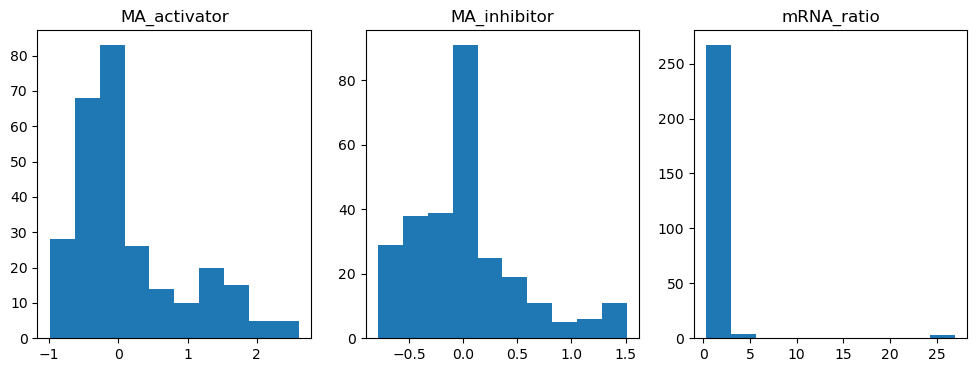

In [77]:
fig, [ax0, ax1, ax2] = plt.subplots(1,3, figsize=[12, 4])
ax0.hist(ratios_df.MA_activator)
ax0.set_title('MA_activator')

ax1.hist(ratios_df.MA_inhibitor)
ax1.set_title('MA_inhibitor')

ax2.hist(ratios_df.actual_mRNA_ratio)
ax2.set_title('mRNA_ratio')

### Create the Grid

In [78]:
# DataFrame to hold the Grid
grid = pd.DataFrame(columns = ['mRNA_ratio','grid'], index = ratios_df.index)
grid.loc[:,'mRNA_ratio'] = ratios_df.loc[:,'actual_mRNA_ratio']

# Load the equation
# NOTE: This equation was generated using Mathematica and Dan's Mathematica to Python converter function
equation = sympify('Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
KeqOpening)*RNAP))')
equation

Eq(mRNARatio, (KdRNAP*cActivator + KdRNAPCrp)*(KdRNAP + KeqOpening*RNAP + RNAP)/(KdRNAP*KdRNAPCrp*(cActivator + cInhibitor + 1) + KdRNAP*RNAP*cActivator*(KeqOpening + 1) + KdRNAPCrp*RNAP*(KeqOpening + 1)))

In [79]:
# Create lambda functions that we can plug in to
lambda_df = ps.create_lambdas(equation, grid_constants)

cAct_range = {'cActivator': [0,2]} # Use a log10 range
cInh_range = {'cInhibitor': [-1,4]} # Use a log10 range and convert back after creating grid

for i, condition in enumerate(grid.index):
    # Create a working grid based on cActivator, we will add cInhibitor values 
    # to it to ensure they always result in mRNA ratio
    cAct_grid = ps.create_parameter_grid(num_steps = 101, **cAct_range)
    cAct_grid = [[10**x[0]] for x in cAct_grid]
    cInh_grid = ps.create_parameter_grid(num_steps = 101, **cInh_range)
    cInh_grid = [[10**x[0]] for x in cInh_grid]

    # Use a dict just in case order of tuple to sub into lambda function ever changes
    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(cAct_grid):
        values['cActivator'] = pair[0] # Add cAct to values dict
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc['cInhibitor','order']])
    
        # Evaluate the lambda function
        cAct_grid[ii] = (cAct_grid[ii][0], (lambda_df.loc['cInhibitor','lambda'](values_tuple))[0])

    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(cInh_grid):
        values['cInhibitor'] = pair[0] # Add cInh to values dict
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc['cActivator','order']])
    
        # Evaluate the lambda function
        cInh_grid[ii] = ((lambda_df.loc['cActivator','lambda'](values_tuple))[0], cInh_grid[ii][0]) # Need to reverse the tuples to maintain (cAct, cInh) order when combining the two grids

    working_grid = sorted(cAct_grid + cInh_grid)
    
    # Remove negative elements from working_grid
    if flags['neg_grid_toss_OR_zero'] == 'toss':
        working_grid = [(cAct, cInh) for (cAct, cInh) in working_grid if cAct >= 0 and cInh >= 0]
    elif flags['neg_grid_toss_OR_zero'] == 'zero':
        new = []
        for cAct, cInh in working_grid:
            if cAct >= 0 and cInh >= 0:
                new.append((cAct, cInh))
            elif cAct < 0 and cInh < 0:
                new.append((0, 0))
            elif cAct < 0:
                new.append((0, cInh))
            else: # this is cInh is negative and cAct isn't
                new.append((cAct, 0))
        working_grid = new
        
    # Save to grid df
    grid.at[condition, 'grid'] = working_grid

### Scatter Condition's Grid with Histograms

Text(0.5, 0.98, 'Condition: control__wt_glc__1')

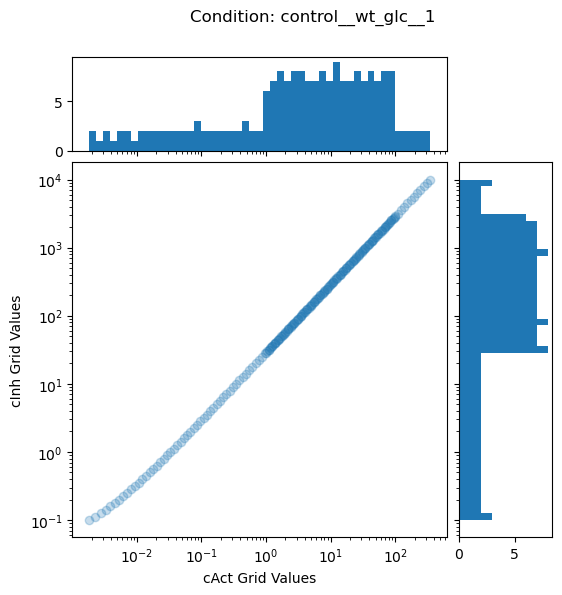

In [80]:
i = 0 # The integer corresponding to the condition of interest index

x = [cAct for (cAct, _) in grid.iloc[i,1]]
y = [cInh for (_, cInh) in grid.iloc[i,1]]

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# no labels
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

# the scatter plot:
ax.scatter(x, y, alpha=0.25)

x_bins = np.logspace(np.log10(min(x)), np.log10(max(x)), 50)
y_bins = np.logspace(np.log10(min(y)), np.log10(max(y)), 50)

ax_histx.hist(x, bins=x_bins)
ax_histy.hist(y, bins=y_bins, orientation='horizontal')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('cAct Grid Values')
ax.set_ylabel('cInh Grid Values')

fig.suptitle('Condition: '+str(grid.index[i]))

## Setup and Run the GA

In [81]:
# Create fitness and individual objects
creator.create(name = 'fitness',
               base = base.Fitness,
               weights = (1.0, -1.0,)) # Set to maximize Spearman correlation of MA_activator and cActivator, and minimize MA_inhibitor and cInhibitor

creator.create(name = 'individual',
               base = np.ndarray,
               shape = (len(grid),), # Number of conditions
               dtype = np.dtype([('act', float), ('inh', float)]), # Custom dtype
               fitness = creator.fitness)

# Import toolbox
toolbox = base.Toolbox()

# Register the individual and population functions
toolbox.register(alias = 'individual',
                 function = ga.generate_individual,
                 individual_class = creator.individual,
                 grid = grid.grid,
                 rng = rng)

toolbox.register('population',
                 tools.initRepeat,
                 list,
                 toolbox.individual)

# Register the evaluation function
toolbox.register(alias = 'evaluate',
                function = ga.spearman_objective,
                MA_df = ratios_df.loc[:,['MA_activator','MA_inhibitor']])

# Register the selection algorithm
toolbox.register(alias = "select", 
                 function = tools.selNSGA2, 
                 nd = 'log') 
# I've been using selNSGA2 since it seems to run faster
#toolbox.register("select", tools.selSPEA2)

# Register the mutation function
toolbox.register(alias = 'mutate', 
                 function = ga.mutate, 
                 prob = flags['mt_prob'], 
                 grid = grid.grid, 
                 rng = rng)

# Register the crossover function
cx_prob = 0.6 # NOTE: These values were chosen based on brute_force.ipynb
toolbox.register(alias = "mate", 
                 function = ga.crossover, 
                 prob = flags['cx_prob'],
                 rng = rng)

# Set the statistics to record the best individual score of each generation in 
# the logbook
stats = tools.Statistics(key=lambda ind: np.subtract(ind.fitness.values[0],
                                                     ind.fitness.values[1]))

# Run the GA
pop, logbook = ga.mu_plus_lambda(pop = toolbox.population(n = flags['n_ind']), 
                                 toolbox = toolbox, 
                                 rng = rng, 
                                 mu = flags['mu'], 
                                 lambda_ = flags['lambda_'], 
                                 cxpb = flags['cxpb'], 
                                 mutpb = flags['mutpb'], 
                                 n_gen = flags['n_gen'], 
                                 stats = stats, 
                                 verbose = flags['verbose'])

/home/chris/mambaforge/envs/TRN_model/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/chris/mambaforge/envs/TRN_model/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


### Check GA Results

In [82]:
total_score, total_sort = ga.best_individual(pop)
total_score[total_sort[-1]]

1.6577492635866102

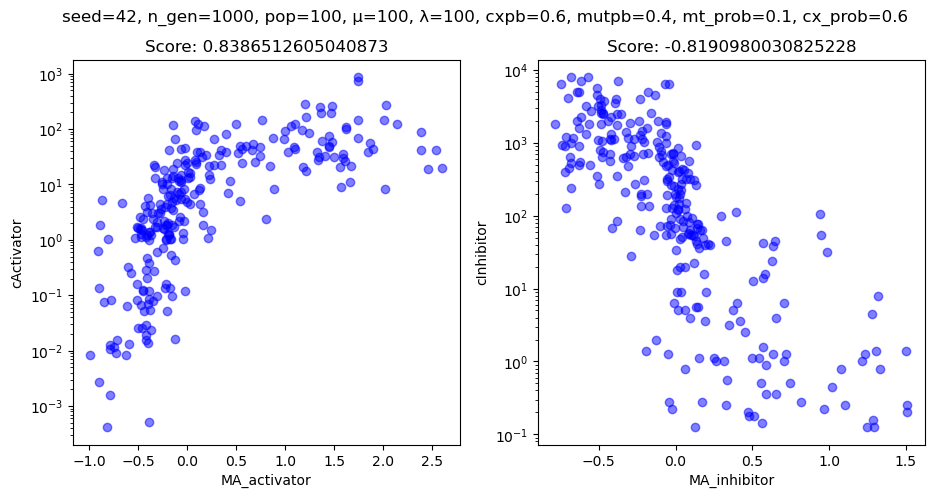

In [83]:
fig, (ax1, ax2) = ga.scatter_individual(ind_one = pop[total_sort[-1]],
                                     MA = ratios_df.loc[:,['MA_activator','MA_inhibitor']],
                                     GA_parameters = flags)

fig.show()

## Run the Greedy Algorithm

In [84]:
greedy_pop = ga.greedy_algorithm(base_individual = pop[total_sort[-1]], 
                                 n_iterations = flags['n_iter'],
                                 grid = grid.grid,
                                 toolbox = toolbox,
                                 max_steps = flags['max_steps'],
                                 n_rounds = flags['n_rounds'])

greedy_score, greedy_sort = ga.best_individual(greedy_pop)
greedy_score[greedy_sort[-1]]

1.933451529813157

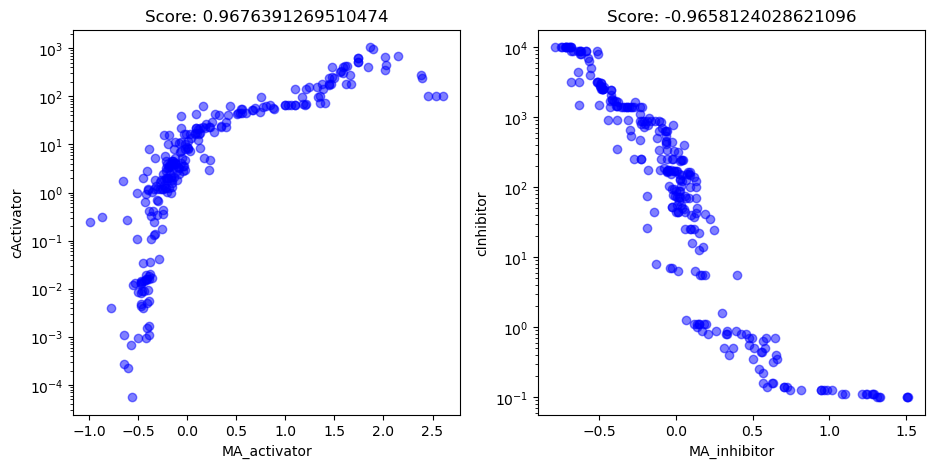

In [85]:
fig, (ax1, ax2) = ga.scatter_individual(ind_one = greedy_pop[greedy_sort[-1]],
                                     MA = ratios_df.loc[:,['MA_activator','MA_inhibitor']],
                                     GA_parameters = None)

fig.show()

### Convert Chosen Individual to DataFrame

In [86]:
GAMs_individual = greedy_pop[greedy_sort[-1]] # TODO: EDIT THIS USING FLAGS?

vals_for_GAMs = pd.DataFrame(index = ratios_df.index,
                             columns = ['cAct', 'cInh'],)

vals_for_GAMs.cAct = list(GAMs_individual['act'])
vals_for_GAMs.cInh = list(GAMs_individual['inh'])

In [87]:
vals_for_GAMs

,cAct,cInh
control__wt_glc__1,8.709636,250.586622
control__wt_glc__2,12.022644,314.452813
fur__wt_dpd__1,0.000000,0.125893
fur__wt_dpd__2,0.000000,0.125893
fur__wt_fe__1,4.168694,177.601275
...,...,...
efeU__menFentCubiC_ale36__2,0.110059,5.623413
efeU__menFentCubiC_ale37__1,0.015290,1.122018
efeU__menFentCubiC_ale37__2,0.013892,1.000000
efeU__menFentCubiC_ale38__1,1.000000,51.741297


In [88]:
# save for GAMs
df_name = flags['central_gene']+'_zerod'+str(flags['use_zerod_A_matrix'])+'_cAct_cInh_vals.csv'
file_out = '../data/save_for_GAMs/'+df_name
vals_for_GAMs.to_csv(file_out)

# run GAMs

In [89]:
# first let's merge together the files
files_use = []
if flags['run_on_all']:
    files = os.listdir('../data/save_for_GAMs/')
    for f in files:
        if 'composite' in f: continue
        if 'zerod'+str(flags['use_zerod_A_matrix']) not in f: continue
        files_use.append(f)
else:
    for sample in flags['limit_samples']:
        f_name = sample+'_zerod'+str(flags['use_zerod_A_matrix'])+'_cAct_cInh_vals.csv'
        if os.path.exists('../data/save_for_GAMs/'+f_name):
            files_use.append(f_name)
for f in files_use:
    act_df = pd.DataFrame(index = ratios_df.index)
    inh_df = pd.DataFrame(index = ratios_df.index)
    for file in files_use:
        gene_name = file.split('_')[0]
        act_df[gene_name] = pd.read_csv('../data/save_for_GAMs/'+file)['cAct'].values
        inh_df[gene_name] = pd.read_csv('../data/save_for_GAMs/'+file)['cInh'].values
act_df.to_csv('../data/save_for_GAMs/composite_cAct_vals.csv')
inh_df.to_csv('../data/save_for_GAMs/composite_cInh_vals.csv')

In [91]:
# this is not directly integrated, to run this part:
# 1 - move the two composite csv files from ../data/save_for_GAMs/ to  Dropbox (UCSD SBRG)\TRN_iM_modeling\GAMS\chris_testing\input
# 2 - Load toy_model_v2.gms from \Dropbox (UCSD SBRG)\TRN_iM_modeling\GAMS\chris_testing\
# 3 - run model
# 4 - move excel files from Dropbox (UCSD SBRG)\TRN_iM_modeling\GAMS\chris_testing\output to ../data/GAMS_output

kd min = 1.0471285480508985e-07
kd max = 2.735963265239082e-07
TF_conc min = 1e-09
TF_conc max = 1e-05


/tmp/ipykernel_815022/3112666288.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


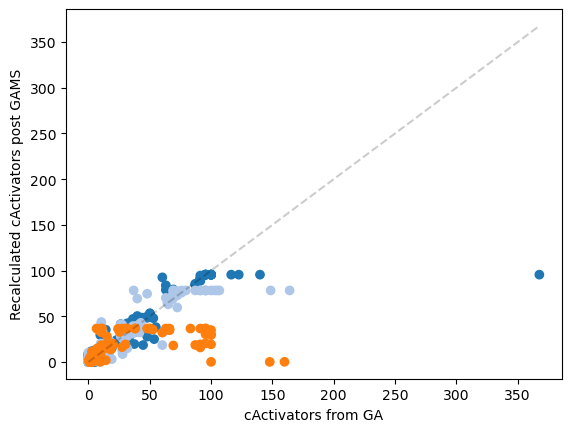

Correlation = 0.82


In [92]:
# look at GAMs results
# load in cActivators
saved_cActivators = pd.read_csv('../data/save_for_GAMs/composite_cAct_vals.csv', index_col = 0)


# GAMS calculated cActivators
kd_df = 10**pd.read_excel('../data/GAMS_output/Kd_results.xlsx').astype(float)
saved_cActivators= saved_cActivators[kd_df.columns]
TF_conc_df = 10**pd.read_excel('../data/GAMS_output/TF_conc_results.xlsx').astype(float)
calc_cAct = pd.DataFrame(index = saved_cActivators.columns, columns = saved_cActivators.index)
cActs = []
for sample in calc_cAct.columns:
    for gene in calc_cAct.index:
        calc_cAct.at[gene, sample] = TF_conc_df[sample].values[0] / kd_df[gene].values[0]
calc_cAct = calc_cAct.T

# max and min values of GAMs results
print('kd min = '+str(min(kd_df.values.flatten())))
print('kd max = '+str(max(kd_df.values.flatten())))
print('TF_conc min = '+str(min(TF_conc_df.values.flatten())))
print('TF_conc max = '+str(max(TF_conc_df.values.flatten())))

# plotting
saved = []
calc = []
labels = []
gene_to_color = {}
cmap = cm.get_cmap('tab20')
color_opts = iter(cmap.colors)
colors = []
for gene in calc_cAct.columns:
    if gene not in gene_to_color:
        gene_to_color.update({gene : next(color_opts)})
    color = gene_to_color[gene]
    for sample in calc_cAct.index:
        saved.append(saved_cActivators.loc[sample][gene])
        calc.append(calc_cAct.loc[sample][gene])
        labels.append(gene+', '+sample)
        colors.append(color)
fig, ax = plt.subplots()
scatter = plt.scatter(saved, calc, c = colors)
plt.plot([0, max(saved_cActivators.values.flatten())], [0, max(saved_cActivators.values.flatten())], alpha = 0.2, c = 'k', linestyle = '--')
plt.xlabel('cActivators from GA')
plt.ylabel('Recalculated cActivators post GAMS')
#plt.yscale('log')
#plt.xscale('log')
plt.show()

# correlation
corr = np.corrcoef(saved, calc)
print('Correlation = {:.2f}'.format(corr[1][0]))

# convert back to mRNA ratios

# plotting